# Cyberbullying On Social Media

# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math

# ! pip install imbalanced-learn
# check version number
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Add, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from PIL import Image

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work well for:

- Analysis of a time series of sensor data.
- Analysis of signal data over a fixed-length period, for example, an audio recording.
- Natural Language Processing (NLP), although according to my research, Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells might be more promising than CNN as they take into account the proximity of words to create trainable patterns.


CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.

In [2]:
#keep the same random state for reproducibility
RANDOM_STATE = 12

TRAIN_TEST_SPLIT_SIZE = 0.1
VALIDATION_SPLIT_SIZE = 0.2

***

**Utility Functions**

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [5]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [6]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [7]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [8]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [9]:
comments = df['tidy_text'].values
labels = df['label_bullying'].values

In [10]:
w2v_features = np.load('w2v_features.npy', allow_pickle=True)

In [11]:
# Create X/y arrays
comments_w2v = w2v_features
labels_w2v = labels
print('x:', comments_w2v.shape, comments_w2v.dtype) 
print('y:', labels_w2v.shape, labels_w2v.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [12]:
x_train_val_w2v, x_test_w2v, y_train_val_w2v, y_test_w2v = train_test_split(comments_w2v, labels_w2v, stratify = labels_w2v,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, 
                                                  random_state = RANDOM_STATE)

In [13]:
x_train_w2v, x_val_w2v, y_train_w2v, y_val_w2v = train_test_split(x_train_val_w2v, y_train_val_w2v, stratify=y_train_val_w2v, 
                                                                  test_size=VALIDATION_SPLIT_SIZE, 
                                                                  random_state=RANDOM_STATE)

In [14]:
print('x:', x_train_w2v.shape, x_train_w2v.dtype) 
print('y:', y_train_w2v.shape, y_train_w2v.dtype)

x: (7943, 100) float64
y: (7943,) int64


In [15]:
print('x:', x_val_w2v.shape, x_val_w2v.dtype) 
print('y:', y_val_w2v.shape, y_val_w2v.dtype)

x: (1986, 100) float64
y: (1986,) int64


In [16]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_w2v_sm, y_train_w2v_sm = sm.fit_sample(x_train_w2v, y_train_w2v)

In [17]:
x_train_w2v_sm = np.expand_dims(x_train_w2v_sm, axis = 2)
x_val_w2v = np.expand_dims(x_val_w2v, axis = 2)
x_test_w2v = np.expand_dims(x_test_w2v, axis = 2)

**Define the model and metrics**



In [18]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The generic architecture of the model I've decided to use having two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. 

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

For this model, I will expand upon  a standard configuration of 64 parallel feature maps and a kernel size of 3. The feature maps are the number of times the input is processed or interpreted, whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps.
The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the binary cross entropy loss function will be used given that we are learning a binary classification problem.

Additionally, there are two options to vectorize the data in Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This is what we will do here with the Keras Embeddings Layer, and using the pretrained Glove/FastTest embeddings.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This is what we will do with TFIDF and Word2Vec.

This notebook explores another approach to building the classification model. Instead of training the embedding layer, we use the separately learnt word embeddings and then pass to the embedding layer. This approach also allows to use any pre-trained word embedding and also saves the time in training the classification model.
I have used the Gensim implementation of Word2Vec in a previous step, by preparing the text corpus for learning the embedding. This included creating word tokens, removing punctuation, removing stop words etc. The word2vec algorithm then processed the comments sentence by sentence and created the word vectors.

In [19]:
def make_model(filters = 16, add_conv_layer = False, kernel_size = 5, dense = 128, dropout = 0.5):
    
    model = Sequential()
#     model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(x_train_w2v_sm.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    if add_conv_layer:
        model.add(Conv1D(filters=filters*4, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Conv1D(filters=filters*8, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    if dropout:
        model.add(Dropout(rate=dropout))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
    else:
        model.add(Dropout(0.1))

    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each of the 2 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=KERAS_METRICS)
    model.summary()
    return model

In [20]:
model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 16)            96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 16)            1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 352)               0         
_________________________________________________________________
dropout (Dropout)            (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

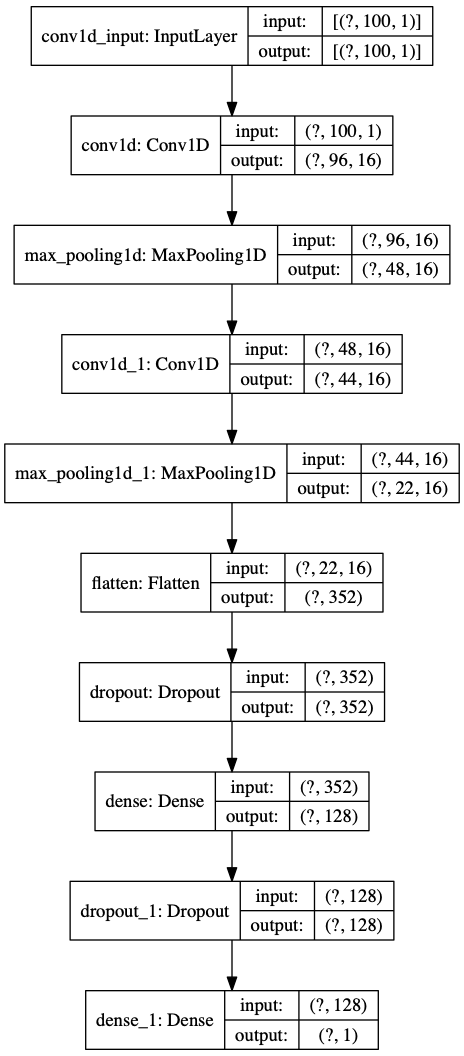

In [21]:
plot_model(model, to_file = 'model_w2v.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_w2v.png')
im

In [22]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [23]:
callbacks = [early_stopping]

In [24]:
BATCH_SIZE = 64
EPOCHS = 100

In [25]:
x_train_w2v_sm = np.asarray(x_train_w2v_sm)
y_train_w2v_sm = np.asarray(y_train_w2v_sm)
x_val_w2v = np.asarray(x_val_w2v)
y_val_w2v = np.asarray(y_val_w2v)
x_test_w2v = np.asarray(x_test_w2v)
y_test_w2v = np.asarray(y_test_w2v)

In [26]:
history = model.fit(x_train_w2v_sm, 
                        y_train_w2v_sm, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_w2v, y_val_w2v))

Train on 11304 samples, validate on 1986 samples
Epoch 1/100
11304/11304 [==============================] - 11s 982us/sample - loss: 0.6582 - tp: 3050.0000 - fp: 1833.0000 - tn: 3819.0000 - fn: 2602.0000 - accuracy: 0.6077 - precision: 0.6246 - recall: 0.5396 - auc: 0.6529 - val_loss: 0.6211 - val_tp: 295.0000 - val_fp: 376.0000 - val_tn: 1037.0000 - val_fn: 278.0000 - val_accuracy: 0.6707 - val_precision: 0.4396 - val_recall: 0.5148 - val_auc: 0.6698 fp: 1643.0000 - tn: 3412.0000 - fn: 2389.0000 - accuracy: 0.6013 - precision: 0.6189 - recall: 0.5276 - auc:
Epoch 2/100
11304/11304 [==============================] - 3s 277us/sample - loss: 0.6181 - tp: 3583.0000 - fp: 1797.0000 - tn: 3855.0000 - fn: 2069.0000 - accuracy: 0.6580 - precision: 0.6660 - recall: 0.6339 - auc: 0.7162 - val_loss: 0.6119 - val_tp: 298.0000 - val_fp: 390.0000 - val_tn: 1023.0000 - val_fn: 275.0000 - val_accuracy: 0.6652 - val_precision: 0.4331 - val_recall: 0.5201 - val_auc: 0.6722
Epoch 3/100
11304/11304 [====

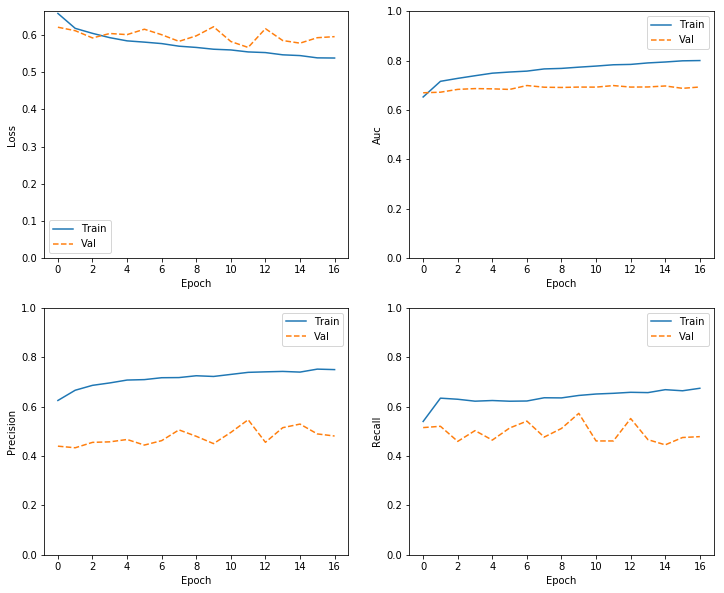

In [27]:
plot_metrics(history)

In [28]:
y_probas_train_w2v = model.predict(x_train_w2v_sm, batch_size = BATCH_SIZE)
y_probas_test_w2v = model.predict(x_test_w2v, batch_size = BATCH_SIZE)

In [29]:
# Get most likely class
y_pred_test_w2v = np.round(y_probas_test_w2v) 

True Negatives:  592
False Positives:  193
False Negatives:  163
True Positives:  156


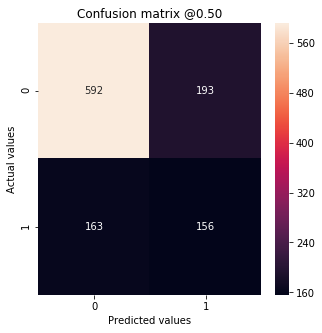

In [30]:
plot_cfm(y_test_w2v, y_pred_test_w2v)

In [31]:
print(classification_report(y_test_w2v, y_pred_test_w2v))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77       785
           1       0.45      0.49      0.47       319

    accuracy                           0.68      1104
   macro avg       0.62      0.62      0.62      1104
weighted avg       0.69      0.68      0.68      1104



In [32]:
f1_keras = f1_score(y_test_w2v, y_pred_test_w2v, average = 'weighted')
print('W2V F1: %.2f' % f1_keras)

W2V F1: 0.68


In [33]:
# Use predict_proba(X)[:, 1] to extract the probability that samples belong to the bullying class.
auc_keras = roc_auc_score(y_test_w2v, y_probas_test_w2v)
print('W2V AUC: %.2f' % auc_keras)

W2V AUC: 0.68


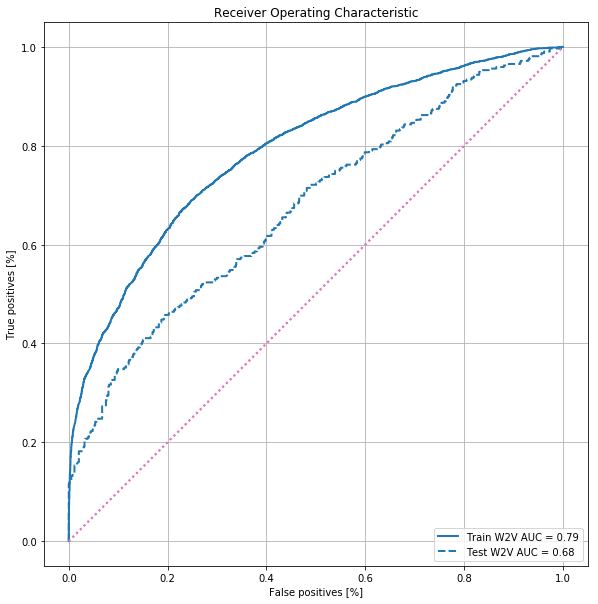

In [34]:
plot_roc("Train W2V", y_train_w2v_sm, y_probas_train_w2v, color = colors[0])
plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[0], linestyle='--')